# **Chatbot Development**

# Crawl data


In [ ]:
import requests
from bs4 import BeautifulSoup
import html

def get_data_from_url(url):
    response = requests.get(url)
    response.encoding = 'utf-8'

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        elements = soup.find_all(['h2', 'p', 'i', 'li'])
        data = []
        for element in elements:
            tag_name = element.name
            text_content = html.unescape(element.get_text(strip=True))
            if tag_name == 'h2' and text_content in ["Accessing Your Personal Information", "Automated Edit Checks"]:
                tag_name = 'h3'
            data.append((tag_name, text_content))
        return data
    else:
        raise Exception(f"Lỗi {response.status_code}: Không thể truy cập trang web")

url = "https://www.presight.io/privacy-policy.html"
try:
    data = get_data_from_url(url)
    for idx, (tag, text) in enumerate(data, 1):
        print(f"{idx}: [{tag}] {text}")
except Exception as e:
    print(e)

1: [p] By Role
2: [p] By Team
3: [h2] PRIVACY POLICY
4: [h2] Last updated 15 Sep 2023
5: [p] At Presight, we are committed to protecting the privacy of our customers and visitors to our website. This Privacy Policy explains how we collect, use, and disclose information about our customers and visitors.
6: [h2] Information Collection and Use
7: [p] We collect several different types of information for various purposes to provide and improve our Service to you.
8: [h2] Types of Data Collected
9: [i] Personal Data
10: [p] While using our Service, we may ask you to provide us with certain personally identifiable information that can be used to contact or identify you ("Personal Data"). Personally identifiable information may include, but is not limited to:
11: [li] Email address
12: [li] First name and last name
13: [li] Phone number
14: [li] Address, State, Province, ZIP/Postal code, City
15: [li] Cookies and Usage Data
16: [i] Usage Data
17: [p] We may also collect information that your 

# Prepare mapping data

* Tạo một DataFrame ánh xạ mỗi phần tử vào mục lớn chứa nó, giúp dễ dàng quản lý cấu trúc phân cấp.

In [ ]:
import pandas as pd
# Ánh xạ một mục đến mục lớn của nó
def refined_map_hierarchy(data):
    result = []
    current_h2 = None
    current_h3_or_i = None
    current_p = None

    for item in data:
        if item[0] == 'h2':
            current_h2 = item[1]
            current_h3_or_i = None
            current_p = None
            result.append((item[1], None))  # h2 không ánh xạ
        elif item[0] in ['h3', 'i']:
            current_h3_or_i = item[1]
            result.append((item[1], current_h2))  # h3 hoặc i ánh xạ đến h2
        elif item[0] == 'p':
            current_p = item[1]
            if current_h3_or_i:
                result.append((item[1], current_h3_or_i))  # p ánh xạ đến h3 hoặc i
            else:
                result.append((item[1], current_h2))  # nếu không có h3/i thì ánh xạ đến h2
        elif item[0] == 'li':
            if current_p:
                result.append((item[1], current_p))  # li ánh xạ đến p
            else:
                result.append((item[1], current_h2))  # nếu không có p ánh xạ đến h2

    return result

refined_hierarchy = refined_map_hierarchy(data)

# Add vào df để dễ quản lý
df_refined_hierarchy = pd.DataFrame(refined_hierarchy, columns=["Current Item", "Mapped To"])

* Ánh xạ một mục tới các mục lớn, mục nhỏ và mục ngang cấp để tổng hợp đầy đủ thông tin liên quan.

In [ ]:
def generate_mapping_paragraph(df, target):
    # Tìm mục mà mục đó ánh xạ tới
    maps_to = df[df['Current Item'] == target]['Mapped To'].values
    maps_to = [str(item) for item in maps_to if item is not None]
    maps_to_str = ", ".join(maps_to) if len(maps_to) > 0 else "None"

    # Tìm tất cả các mục ánh xạ tới mục đó
    mapped_to_by = df[df['Mapped To'] == target]['Current Item'].values
    mapped_to_by = [str(item) for item in mapped_to_by if item is not None]
    mapped_to_by_str = ", ".join(mapped_to_by) if len(mapped_to_by) > 0 else "None"

    # Tìm tất cả các mục cùng ánh xạ tới mục mà mục hiện tại ánh xạ tới
    same_maps_to = []
    if maps_to:
        for item in maps_to:
            same_maps_to += df[df['Mapped To'] == item]['Current Item'].values.tolist()
        same_maps_to = list(set(same_maps_to) - {target})  # Loại bỏ mục hiện tại khỏi danh sách
        same_maps_to_str = ", ".join(map(str, same_maps_to)) if len(same_maps_to) > 0 else "None"
    else:
        same_maps_to_str = "None"

    # Tạo DataFrame tạm thời
    mappings_result_df = pd.DataFrame({
        'Type': ['Previous', 'Target', 'Same index', 'Next'],
        'Content': [maps_to_str, target, same_maps_to_str, mapped_to_by_str]
    })


    # Tạo đoạn văn từ df đó
    paragraph = "\n".join(str(content) for content in mappings_result_df['Content'].tolist())
    return paragraph

# Preprocessing

In [ ]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy

# Tải mô hình ngôn ngữ spaCy
nlp = spacy.load('en_core_web_sm')

In [ ]:
class Preprocessing():
  def __init__(self):
        self.stop_words = ENGLISH_STOP_WORDS
  def lowercasing(self,text):
        return text.lower()
  def remove_noise(self,text):
        text = re.sub(r'http[s]?://\S+', '', text)  # Xóa URL
        text = re.sub(r'\S+@\S+', '', text)  # Xóa địa chỉ email
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Xóa ký tự đặc biệt và số
        return text
  def tokenize(self,text):
        return text.split()
  def lemmatize(self, tokens):
        """Đưa các từ về dạng gốc sử dụng spaCy"""
        doc = nlp(" ".join(tokens))  # Chuyển tokens thành văn bản và xử lý bằng spaCy
        return [token.lemma_ for token in doc]
  def remove_stopwords(self, tokens):
        return [word for word in tokens if word.lower() not in self.stop_words]
  def preprocess(self, text):
        text = self.lowercasing(text)
        text = self.remove_noise(text)
        tokens = self.tokenize(text)
        tokens = self.lemmatize(tokens)
        tokens = self.remove_stopwords(tokens)
        return tokens

# Embedding

In [ ]:
from sentence_transformers import SentenceTransformer

# Khởi tạo mô hình SentenceTransformer
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding_from_text(text):
    embedding = embedding_model.encode(text)
    return embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import json
preprocessor = Preprocessing()

output_data = []

for idx, (item, content) in enumerate(data):
    processed_content = preprocessor.preprocess(content)  # Áp dụng tiền xử lý cho content
    processed_text = " ".join(processed_content)

    # Embedding văn bản đã preprocess
    embedding =  get_embedding_from_text(processed_text)

    output_data.append({
        "content": content,
        "processed_content": json.dumps(processed_content),
        "embedding": embedding
    })

# Tìm ra 3 đoạn nội dung liên quan nhất

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_top3_match(question, index):
    # Preprocess và tính embedding cho question
    ques_preprocess = preprocessor.preprocess(question)
    question_embedding = get_embedding_from_text(" ".join(ques_preprocess))

    similarities = []

    for entry in index:
        # Tính cosine similarity
        similarity = cosine_similarity([question_embedding], [entry["embedding"]])[0][0]
        similarities.append({"content": entry["content"], "score": similarity})

    # Sắp xếp theo điểm tương đồng giảm dần
    similarities.sort(key=lambda x: x["score"], reverse=True)

    # Trả về 3 đoạn văn có điểm cao nhất
    return similarities[:3] if similarities else None

# Tạo prompt để trả lời câu hỏi

In [ ]:
import time
import google.generativeai as genai

# Cấu hình API Gemini
genai.configure(api_key="your_api_key")
model = genai.GenerativeModel("gemini-1.5-flash")

def make_request(question):
    start = time.time()

    # Tìm đoạn phù hợp nhất
    find_match = find_top3_match(question, model.data)

    passage = []
    for item in find_match:
      paragraph = generate_mapping_paragraph(model.data_mapping, (item["content"]))
      passage.append(paragraph)

    # Tạo prompt từ đoạn phù hợp và câu hỏi
    prompt = f"Based on the following passage: {passage}. Select the ideas and answer the questions: {question}"

    try:
        response = model.generate_content(prompt) #trả về câu trả lời từ model gemini
        answer = response.text.strip()
    except Exception as e:
        answer = f"Error: {e}"

    end = time.time()
    print(f"Query processed in {end - start:.2f} seconds")

    return answer

# Gắn data đã chuẩn bị vào model
model.data = output_data
model.data_mapping = df_refined_hierarchy
# Gắn hàm make_request vào model
model.make_request = make_request

# Giao diện người dùng

In [ ]:
import gradio as gr

def process_question(question):
    if hasattr(model, "make_request"):
        answer = model.make_request(question)
        return answer
    return "Model is error"


def main():
    with gr.Blocks() as interface:
        gr.Markdown("""# Privacy Policy Q&A
        This application allows users to ask questions about the privacy policy content.
        """)

        with gr.Column():

            question = gr.Textbox(label="Enter your question", placeholder="Type your question here...")


            submit_button = gr.Button("Submit")


            answer = gr.Textbox(label="Answer", placeholder="The response will appear here...", interactive=False)

        submit_button.click(process_question, inputs=question, outputs=answer)
    interface.launch(share = True)

if __name__ == "__main__":
    main()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bf0832cfb14680abe8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Sample results

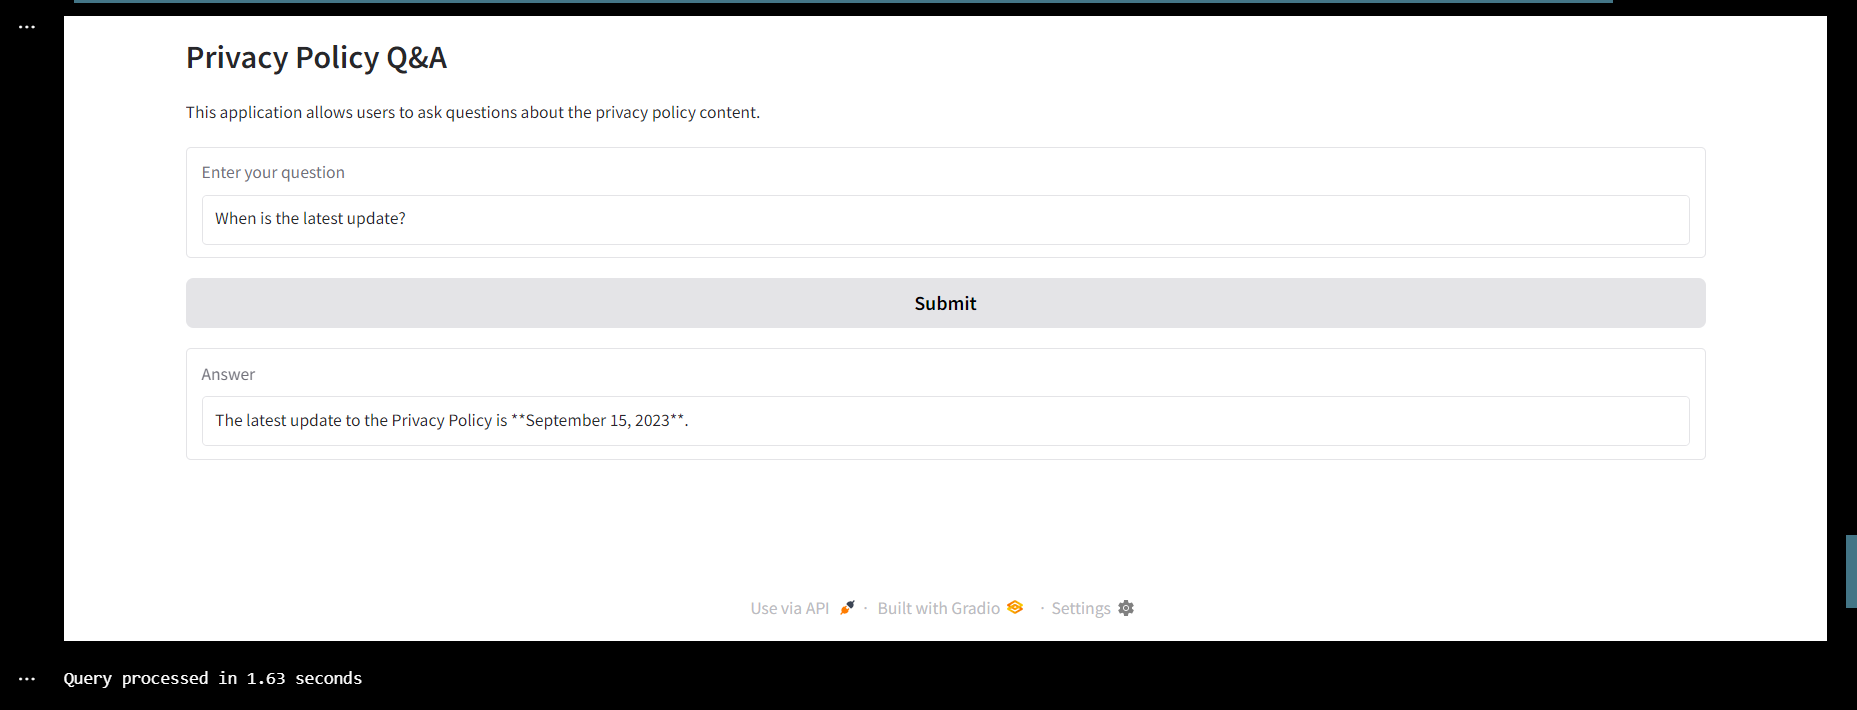

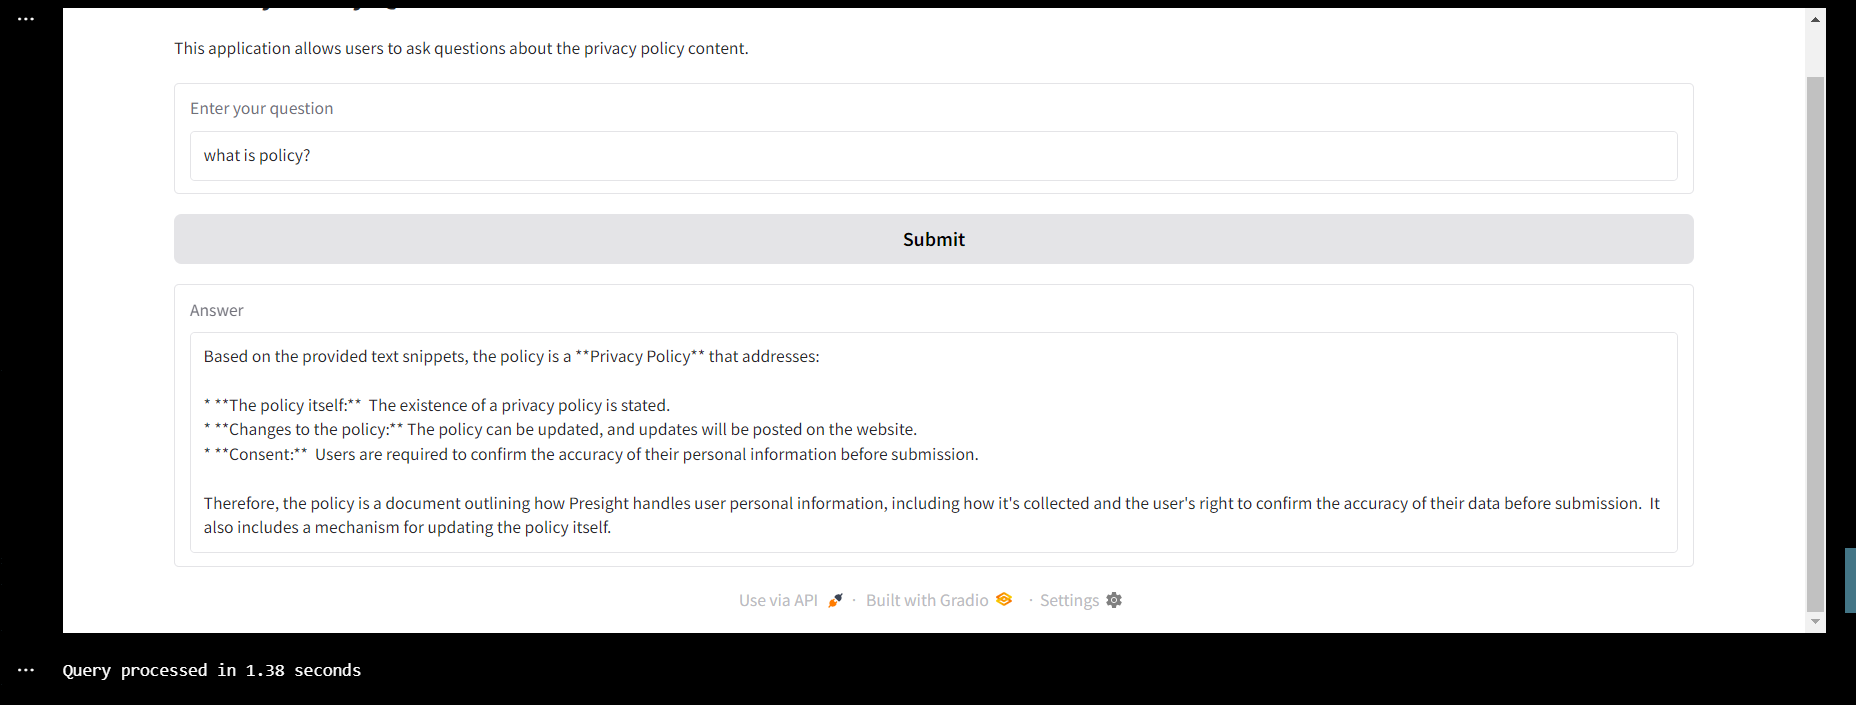

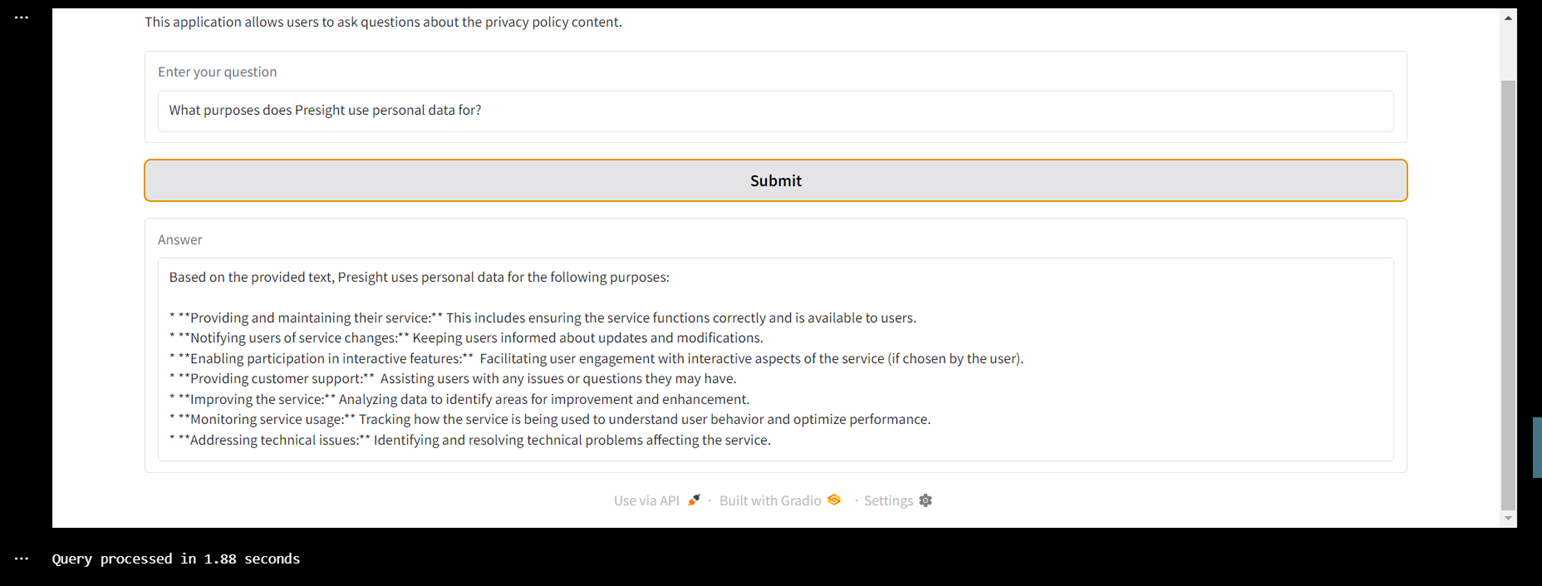